In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Utforske Data

### Data fra finn.no boligannonser er sist oppdatert 07.10.23

In [2]:
df = pd.read_csv('all_regions.csv')
df.head()

,url,prisantydning,totalpris,megler,by,adresse,omkostninger,felleskost_mnd,kommunale_avg,formuesverdi,boligtype,eieform,soverom,primærrom,bruksareal,tomteareal,bruttoareal,byggeår,energimerking,om_boligen
0,https://www.finn.no/realestate/homes/ad.html?f...,4200000,4325670,PrivatMegleren Østbø & Kaldheim,Kolnes,"Hestfaret 61, 5541 Kolnes",125670.0,NaN,15518.0,778662.0,e,e,4.0,180.0,185.0,623.0,NaN,1987.0,E,NaN
1,https://www.finn.no/realestate/homes/ad.html?f...,4000000,4101370,EIE eiendomsmegling - Rogaland Eiendomsmegling AS,Hafrsfjord,"Hottavikstraen 17, 4048 Hafrsfjord",101370.0,NaN,14672.0,1036464.0,e,e,2.0,106.0,125.0,542.0,NaN,1949.0,F,NaN
2,https://www.finn.no/realestate/homes/ad.html?f...,4290000,4398592,DNB Eiendom AS,Sola,"Sandesletta 23G, 4050 Sola",108592.0,3074.0,NaN,NaN,l,e,2.0,79.0,92.0,1154.0,NaN,2018.0,C,Leiligheten bærer preg av forsiktig bruk og ho...
3,https://www.finn.no/realestate/homes/ad.html?f...,3990000,4310477,Privatmegleren Galleri,Stavanger,"Eiganesveien 176, 4009 Stavanger",116092.0,3928.0,12596.0,964438.0,l,e,2.0,95.0,95.0,3271.0,NaN,1990.0,F,NaN
4,https://www.finn.no/realestate/homes/ad.html?f...,1490000,1528592,DNB Eiendom AS,Haugesund,"Veslevegen 4, 5515 Haugesund",38592.0,1500.0,7660.0,419030.0,l,e,1.0,60.0,123.0,920.0,134.0,1921.0,F,Overflatene i boligen holder jevnt over god st...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15022 entries, 0 to 15021
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             15022 non-null  object 
 1   prisantydning   15022 non-null  int64  
 2   totalpris       15022 non-null  int64  
 3   megler          14331 non-null  object 
 4   by              15022 non-null  object 
 5   adresse         15022 non-null  object 
 6   omkostninger    14748 non-null  float64
 7   felleskost_mnd  7831 non-null   float64
 8   kommunale_avg   9023 non-null   float64
 9   formuesverdi    12480 non-null  float64
 10  boligtype       15022 non-null  object 
 11  eieform         15022 non-null  object 
 12  soverom         14761 non-null  float64
 13  primærrom       14956 non-null  float64
 14  bruksareal      14940 non-null  float64
 15  tomteareal      13969 non-null  float64
 16  bruttoareal     2088 non-null   float64
 17  byggeår         14791 non-null 

### Fjern kolonner med få non-null oppføringer

In [4]:
df = df.drop(columns=["url", "felleskost_mnd", "kommunale_avg", "bruttoareal", "om_boligen", ], axis=1)
df.head()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11039 entries, 0 to 15021
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prisantydning  11039 non-null  int64  
 1   totalpris      11039 non-null  int64  
 2   megler         11039 non-null  object 
 3   by             11039 non-null  object 
 4   adresse        11039 non-null  object 
 5   omkostninger   11039 non-null  float64
 6   formuesverdi   11039 non-null  float64
 7   boligtype      11039 non-null  object 
 8   eieform        11039 non-null  object 
 9   soverom        11039 non-null  float64
 10  primærrom      11039 non-null  float64
 11  bruksareal     11039 non-null  float64
 12  tomteareal     11039 non-null  float64
 13  byggeår        11039 non-null  float64
 14  energimerking  11039 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 1.3+ MB


### Sjekk hvilke byer som har de dyreste boligene

In [5]:
# Konverter priskolonner til numeriske verdier
df['prisantydning'] = pd.to_numeric(df['prisantydning'], errors='coerce')
df['totalpris'] = pd.to_numeric(df['totalpris'], errors='coerce')

# Grupper etter "by", bergegn gjennomsnittspriser og sorter
city_mean_prices = df.groupby('by').agg({'prisantydning': ['mean', 'count']})
city_mean_prices.columns = ['mean_price', 'count']
city_mean_prices_sorted = city_mean_prices.sort_values(by='mean_price', ascending=False)

pd.options.display.float_format = '{:.0f}'.format

meanPrice_df = city_mean_prices_sorted.reset_index()

### Sjekk priser i de 4 største byene

In [6]:
biggest_citys = ["Oslo", "Bergen", "Trondheim", "Stavanger"]
for i in biggest_citys:
    city_price = meanPrice_df[meanPrice_df['by'] == i]
    print(city_price.to_string(header=False, index=False))

Oslo 8317048 1381
Bergen 4542981 208
Trondheim 5746407 334
Stavanger 5662396 144


### Top 10 dyreste byer

In [7]:
meanPrice_df.head(10)

,by,mean_price,count
0,Nesøya,18200000,4
1,Jar,14897500,4
2,Vollen,14023000,10
3,Bekkestua,13005294,17
4,Kjøpmannskjær,12933333,3
5,Husøysund,12767222,9
6,Blommenholm,12270833,6
7,Hosle,12238571,7
8,Nærsnes,12233333,3
9,Vestskogen,12186000,5


### Top 10 rimeligste byer

In [8]:
meanPrice_df.tail(10)

,by,mean_price,count
1106,Risdal,650000,1
1107,Ålen,643333,3
1108,Gryllefjord,600000,1
1109,Bindalseidet,535000,2
1110,Bygland,525000,1
1111,Hamarøy,500000,1
1112,Salten,420000,1
1113,Limingen,320000,1
1114,Abelvær,250000,1
1115,Kjøpsvik,150000,1


# 2. Preprosessering

### Bruk etikettkoding (labelencoding) for å konvertere kategorisk data til numerisk

In [9]:
le = LabelEncoder()
columns_transform = ["megler", "by", "adresse", "boligtype", "eieform", "energimerking"]
for col in columns_transform:
    df[col] = le.fit_transform(df[col])

    # Fjern dupliserte rader
df.drop_duplicates(inplace=True)

df.head()

,prisantydning,totalpris,megler,by,adresse,omkostninger,formuesverdi,boligtype,eieform,soverom,primærrom,bruksareal,tomteareal,byggeår,energimerking
0,4200000,4325670,551,455,3342,125670,778662,0,1,4,180,185,623,1987,4
1,4000000,4101370,111,287,3549,101370,1036464,0,1,2,106,125,542,1949,5
3,3990000,4310477,553,863,1485,116092,964438,1,1,2,95,95,3271,1990,5
4,1490000,1528592,103,310,10000,38592,419030,1,1,1,60,123,920,1921,5
5,2850000,2922592,103,863,4868,72592,636201,1,1,2,70,73,1029,2000,3


### Sjekk alle kolonner sitt forhold til pris

In [10]:
def relations_grid(df):
    plot_columns = df.columns.tolist()

    columns = 3
    rows = 5
    n = 0

    fig = plt.figure(figsize=(15,15))
    grid = plt.GridSpec(rows, columns, hspace=1)

    for i in range(1,columns*rows+1):
        ax = plt.subplot(grid[i - 1])
        sns.scatterplot(data=df,x=plot_columns[n],y="prisantydning")
        plt.title(f"{plot_columns[n].upper()} - Pris")
        n+=1
    plt.show()

### Rutenett

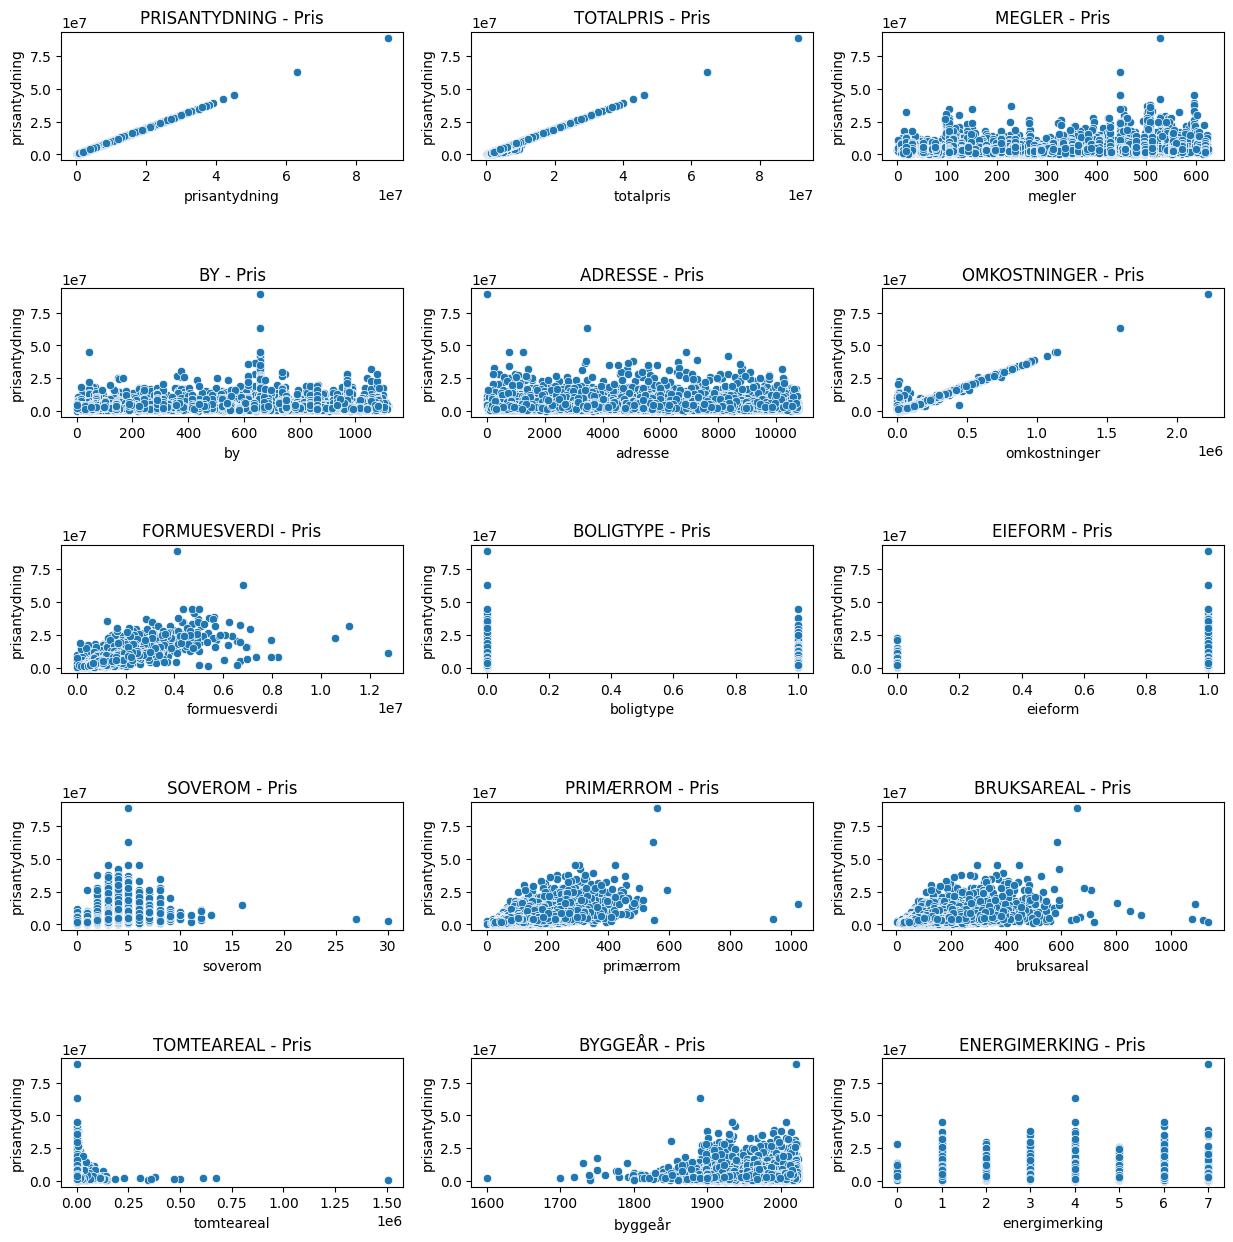

In [11]:
relations_grid(df)

### Varmekart

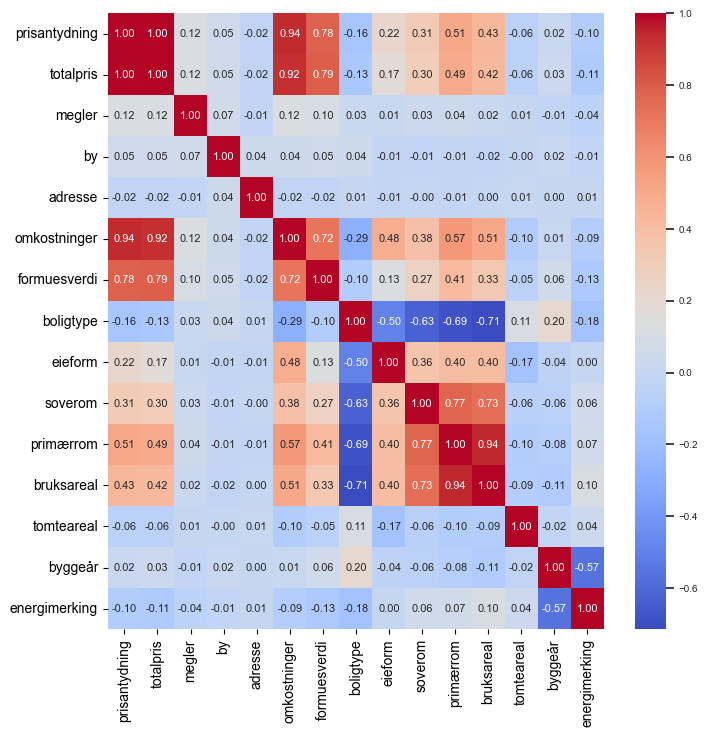

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=0.65)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [13]:
def find_corr(df, column):
    # beregn korrelasjon mellom klassene og kolonnene
    corr_with_classes = df.corrwith( df[column])

    # Konverter den resulterende serien til en liste av lister med 2 desimaler
    corr_list = [[col, round(corr_with_classes[col],2)] for col in corr_with_classes.index]
    corr_list_sorted = sorted(corr_list, key=lambda x: x[1])
                              
    return corr_list_sorted

In [14]:
corr_list = find_corr(df, "prisantydning")
for i in corr_list:
    print(i)

['boligtype', -0.16]
['energimerking', -0.1]
['tomteareal', -0.06]
['adresse', -0.02]
['byggeår', 0.02]
['by', 0.05]
['megler', 0.12]
['eieform', 0.22]
['soverom', 0.31]
['bruksareal', 0.43]
['primærrom', 0.51]
['formuesverdi', 0.78]
['omkostninger', 0.94]
['prisantydning', 1.0]
['totalpris', 1.0]


In [15]:
# Beregn Z-scores
z_scores = np.abs(stats.zscore(df))

# Sett en tersket (threshold)
threshold = 3

# Identifiser avvik (outliers)
outlier_mask = z_scores > threshold

# Lag en ny DataFrame uten avvikene
df_no_outliers = df[~outlier_mask.any(axis=1)]

df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10415 entries, 0 to 15021
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prisantydning  10415 non-null  int64  
 1   totalpris      10415 non-null  int64  
 2   megler         10415 non-null  int32  
 3   by             10415 non-null  int32  
 4   adresse        10415 non-null  int32  
 5   omkostninger   10415 non-null  float64
 6   formuesverdi   10415 non-null  float64
 7   boligtype      10415 non-null  int32  
 8   eieform        10415 non-null  int32  
 9   soverom        10415 non-null  float64
 10  primærrom      10415 non-null  float64
 11  bruksareal     10415 non-null  float64
 12  tomteareal     10415 non-null  float64
 13  byggeår        10415 non-null  float64
 14  energimerking  10415 non-null  int32  
dtypes: float64(7), int32(6), int64(2)
memory usage: 1.0 MB


### Rutenett - uten avvik (outliers)

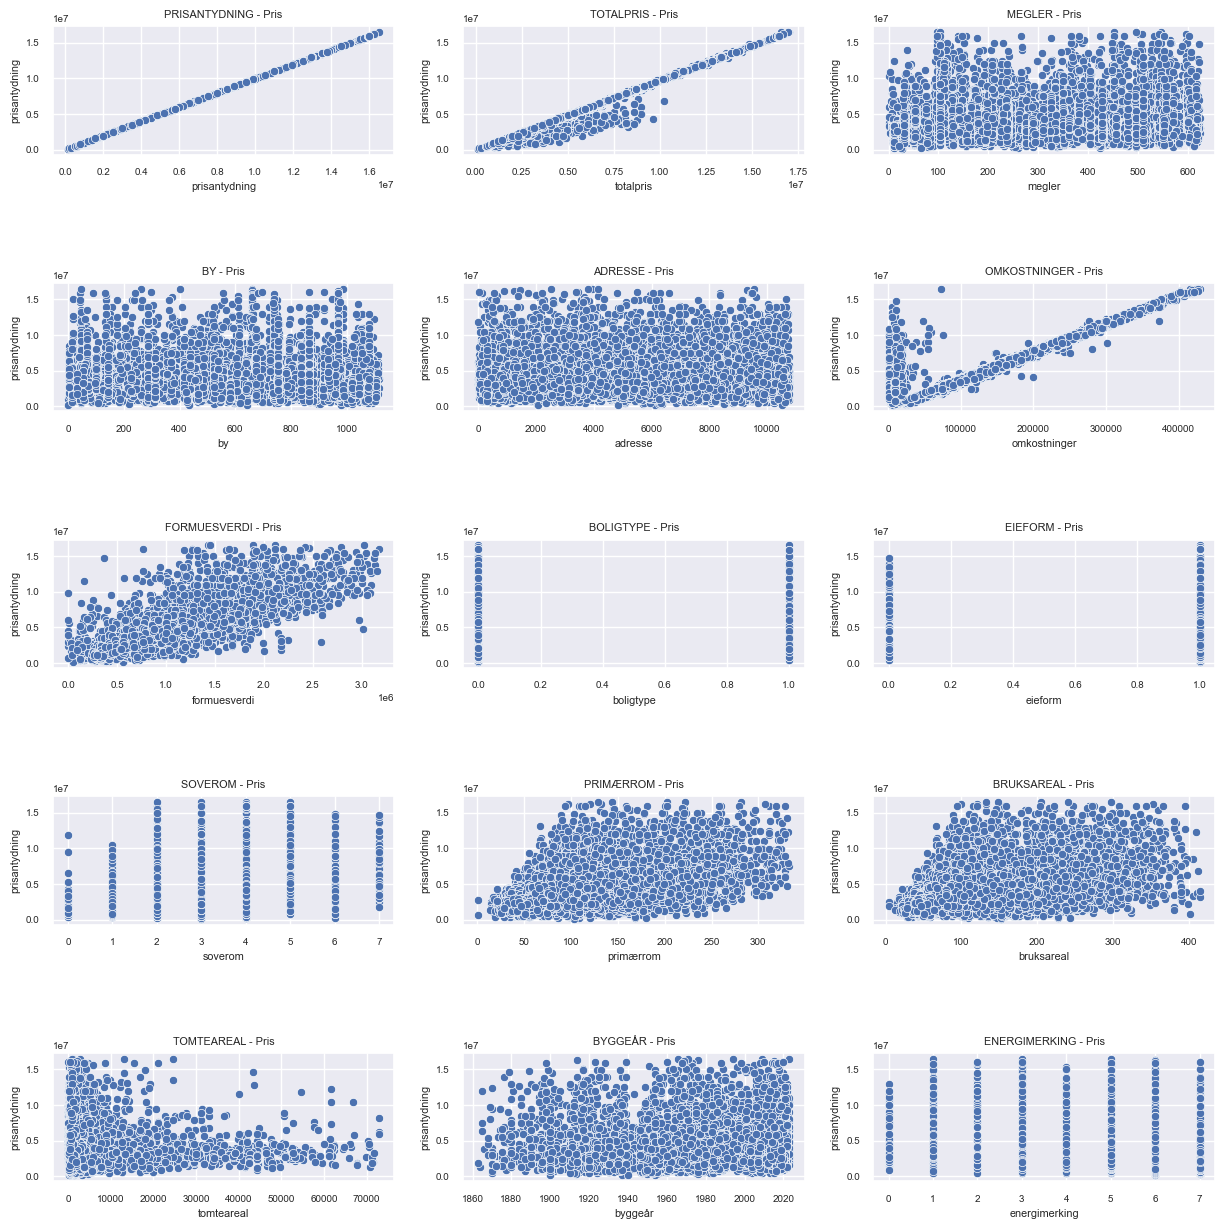

In [16]:
relations_grid(df_no_outliers)

### Planen videre:

DataFrame-en med avvik inneholder 11 039 oppføringer, mens data uten avvik inneholder 10 415 oppføringer. Jeg vil lage en ekstra DataFrame basert på den med avvik, men denne gangen vil jeg justere det totale antallet oppføringer til det samme som DataFrame-en uten avvik (oppføringer som skal fjernes, velges tilfeldig) for å se hvilken effekt dette vil ha på resultatene når modellen trenes.

In [17]:
desired_num_entries = 10415
entries_to_remove = len(df) - desired_num_entries
indices_to_remove = np.random.choice(df.index, entries_to_remove, replace=False)
df_subset = df.drop(indices_to_remove)

df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10415 entries, 0 to 15020
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prisantydning  10415 non-null  int64  
 1   totalpris      10415 non-null  int64  
 2   megler         10415 non-null  int32  
 3   by             10415 non-null  int32  
 4   adresse        10415 non-null  int32  
 5   omkostninger   10415 non-null  float64
 6   formuesverdi   10415 non-null  float64
 7   boligtype      10415 non-null  int32  
 8   eieform        10415 non-null  int32  
 9   soverom        10415 non-null  float64
 10  primærrom      10415 non-null  float64
 11  bruksareal     10415 non-null  float64
 12  tomteareal     10415 non-null  float64
 13  byggeår        10415 non-null  float64
 14  energimerking  10415 non-null  int32  
dtypes: float64(7), int32(6), int64(2)
memory usage: 1.0 MB


# 3. Tren/test Lineær Regresjon

In [18]:
def split_data(df):
    X = df.drop(["prisantydning", "totalpris", "formuesverdi"], axis=1)
    y = df["totalpris"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X, y, X_train, X_test, y_train, y_test

In [19]:
def linear_regression(X, y, X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    cv_scores = cross_val_score(model, X, y, cv=5)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean()}")
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

### Modell 1 - inkludert avvik (outliers)

In [20]:
X, y, X_train, X_test, y_train, y_test = split_data(df)
linear_regression(X, y, X_train, X_test, y_train, y_test)

Cross-Validation Scores: [0.9445248  0.92836529 0.95356353 0.93548363 0.92445477]
Mean CV Score: 0.9372784053224436
Mean Absolute Error: 496720.17377581965
Mean Squared Error: 1160934432193.6123
Root Mean Squared Error: 1077466.6733563559
R-squared: 0.9347650362513064


### Modell 2 - uten avvik (outliers)

In [21]:
X, y, X_train, X_test, y_train, y_test = split_data(df_no_outliers)
linear_regression(X, y, X_train, X_test, y_train, y_test)

Cross-Validation Scores: [0.75905563 0.91367632 0.92076961 0.90387549 0.90998015]
Mean CV Score: 0.8814714397135764
Mean Absolute Error: 461321.8201360956
Mean Squared Error: 750526170484.1486
Root Mean Squared Error: 866329.1351929407
R-squared: 0.8866317460784878


### Modell 3 - med avvik, men redusert antall oppføringer

In [22]:
X, y, X_train, X_test, y_train, y_test = split_data(df_subset)
linear_regression(X, y, X_train, X_test, y_train, y_test)

Cross-Validation Scores: [0.94494008 0.93592939 0.95346538 0.9335225  0.92081434]
Mean CV Score: 0.9377343376274331
Mean Absolute Error: 435841.6100131608
Mean Squared Error: 742934543738.2656
Root Mean Squared Error: 861936.5079507107
R-squared: 0.9528260649058721


# 4. Oppsummering

Modell 1 og 3 presterer ganske likt, mens modell 2 lander en del lavere. Dette antyder at avvikene i datasetet inneholder verdifull informasjon. <br> <br>
Resultatene er sterke med høy gjennomsnittsskår i kryssvalidering, lave feil (MAE og MSE), og en høy R-squared-verdi, som indikerer at modellen gir nøyaktige forutsigelser og passer godt til dataene. 